# Piecewise-parabolic interpolation

## The algorithm

In [11]:
import numpy as np 
import matplotlib.pyplot as plt 

ROLL_R = - 1
ROLL_L =   1


def computePPMInterpolation(a, dxi, eta1 = 20, eta2 = 0.05, epsilon = 0.01, fix1 = False, fix2 = False, fix3 = True, axis = 0): 
    #a_i+1
    ap  = np.roll(a,     ROLL_R, axis = axis) 
    #a_i+2
    app = np.roll(a, 2 * ROLL_R, axis = axis) 
    #a_i-1
    am  = np.roll(a,     ROLL_L, axis = axis)
    #a_i-2
    amm = np.roll(a, 2 * ROLL_L, axis = axis)
    

    # Average slope of parabola
    delta_a = 1/2 * (ap - am)
    delta_m = np.minimum(np.abs(delta_a), 2 * np.minimum(np.abs(a - am), np.abs(ap - a))) * np.sign(delta_a)

    cond          = ((ap - a) * ( a - am )) <= 0
    delta_m[cond] = 0

    delta_mm = np.roll(delta_m, ROLL_L, axis = axis)
    delta_mp = np.roll(delta_m, ROLL_R, axis = axis)

    ### Face-centered density approximations obtained via parabolic interpolation
    ### Yields continuous approximation to density 
    #Use fix 3 to get interpolation for delta_m = delta_a for comparison 
    if fix1: 
        ap2 = 7/12 * ( a + ap ) - 1/12 * ( app + am )
    else:
        ap2 = a + 1/2 * ( ap - a ) - 1/6 * (delta_mp - delta_m)
    #a_i-1/2
    am2 = np.roll(ap2, ROLL_L, axis = axis) 

    ### Face-centered density approximations that take into account monotonicity
    ### Potentially discontinuous, shock-resolving approximation to density
    a_R = ap2
    a_L = am2

    ### Switch to different interpolation if we detect discontinuities in a and fix1 is on
    if fix2: 
        # Second derivative as measure for discontinuities
        d2_a  = 1/(6*dxi**2) * (ap - 2*a + am)
        d2_ap = np.roll(d2_a, ROLL_R, axis = axis)
        d2_am = np.roll(d2_a, ROLL_L, axis = axis)

        eta_bar = - ( (d2_ap - d2_am ) / ( 2 * dxi) ) * ( 2*dxi**3 / (ap - am) )

        cond1 = (-d2_ap * d2_am <= 0)
        cond2 = (np.abs(ap - am) - epsilon * np.minimum(np.abs(ap), np.abs(am)) <= 0) 

        eta_bar[cond1] = 0
        eta_bar[cond2] = 0 

        eta = np.maximum(0, np.minimum(eta1 * (eta_bar - eta2), 1))


        a_Ld = am + 1/2 * delta_mm
        a_Rd = ap - 1/2 * delta_mp

        a_L = a_L * ( 1 - eta ) + a_Ld * eta
        a_R = a_R * ( 1 - eta ) + a_Rd * eta

    ### Set coefficients of the interpolating parabola such that it does not overshoot if fix2 is on 
    if fix3: 
        # 1. If a is local extremum, set the interpolation function to be constant
        cond = ((a_R - a)*(a - a_L) <= 0) # cond == True <-> a is local extremum
        a_L[cond] = a[cond]
        a_R[cond] = a[cond]
        
        # 2. If a between a_R and a_L, but very close to them, the parabola might still overshoot
        cond = + (a_R - a_L)**2 / 6 < (a_R - a_L) * (a - 1/2 * (a_L + a_R))
        a_L[cond] = 3 * a[cond] - 2 * a_R[cond]
        cond = - (a_R - a_L)**2 / 6 > (a_R - a_L) * (a - 1/2 * (a_L + a_R))
        a_R[cond] = 3 * a[cond] - 2 * a_L[cond]

    ### Free parameters in approximation polynomial 
    ### a(xi) = a_L + x(d_a + a_6 ( 1 - x ))
    ### where x = (xi - xi_p)/dxi
    d_a =                  a_R - a_L 
    a_6 = 6 * (a - 1/2 * ( a_R + a_L))

    return a_L, a_R, d_a, a_6

## Define the test problems 

In [26]:
def gaussian1D(xx, dx, t=0, x0 = 1, v = 1, alpha = 1/10):
    psi = np.exp(-(xx-x0-t*v)**2/alpha)
    return psi


def tophat1D(xx, dx, t=0, x0 = 1, v = 1, L = 4, w = 1, h = 1):
    x0c = (x0 + v * t)%L
    x0l, x0r = x0c - w/2, x0c + w/2
    psi = h * (xx > x0l) * (xx < x0r)
    return psi

L = 2
N = 100
xx    = np.linspace(0, L, N)
xx_hr = np.linspace(0, L, 100*N)
dx = L/N
y1 = gaussian1D(xx, dx)
y2 = tophat1D(xx, dx) 

yy = [y1, y2]
labels = ["gaussian wave packet", "tophat"]


## Compute interpolation coefficients

In [38]:
interpolation_results = []
for y in yy: 
    result = {}
    #Non-monotonic interpolation
    result["non-monotonic"] = computePPMInterpolation(y, dx, fix1 = True, fix2 = False,  fix3 = False)
    ##Slightly more monotonic interpolation
    result["slightly monotonic"] = computePPMInterpolation(y, dx, fix1 = False, fix2 = False, fix3 = False)
    #Monotonic interpolation
    result["monotonic"] = computePPMInterpolation(y, dx, fix1 = False, fix2 = False, fix3 = True )
    #Monotonic interpolation with discontinuity detection
    result["monotonic with edge detection"] = computePPMInterpolation(y, dx, fix1 = False, fix2 = True,  fix3 = True )

    interpolation_results.append(result)

/tmp/ipykernel_7372/3826663870.py:50: RuntimeWarning: divide by zero encountered in divide
  eta_bar = - ( (d2_ap - d2_am ) / ( 2 * dxi) ) * ( 2*dxi**3 / (ap - am) )
/tmp/ipykernel_7372/3826663870.py:50: RuntimeWarning: invalid value encountered in multiply
  eta_bar = - ( (d2_ap - d2_am ) / ( 2 * dxi) ) * ( 2*dxi**3 / (ap - am) )


## Compare the different interpolation modes

In [39]:


def interpolate_a(xi, dxi, xx, a_L, a_R, d_a, a_6):
    #Interate over all interpolation intervals
    for i, xi_0 in enumerate(xx):
        # Check if xi lies in correct interval
        if (xi_0 - dxi/2 <= xi) and (xi < xi_0+ dxi/2):
            x = (xi - (xi_0 - dxi/2))/dxi
            return a_L[i] + x * (d_a[i] + a_6[i] * ( 1 - x))

interpolated_profiles = {}

for i, test_case in enumerate(interpolation_results):
    interpolated_profiles[labels[i]] = {}

    interpolated_profiles[labels[i]]["original"] = {"xx": xx, "yy": yy[i]}
    for key in test_case.keys(): 
        yy_hr = np.zeros(xx_hr.shape) 
        for j, xi in enumerate(xx_hr): 
            yy_hr[j] = interpolate_a(xi, dx, xx, *test_case[key])
        interpolated_profiles[labels[i]][key] = {"xx": xx_hr, "yy": yy_hr}

            


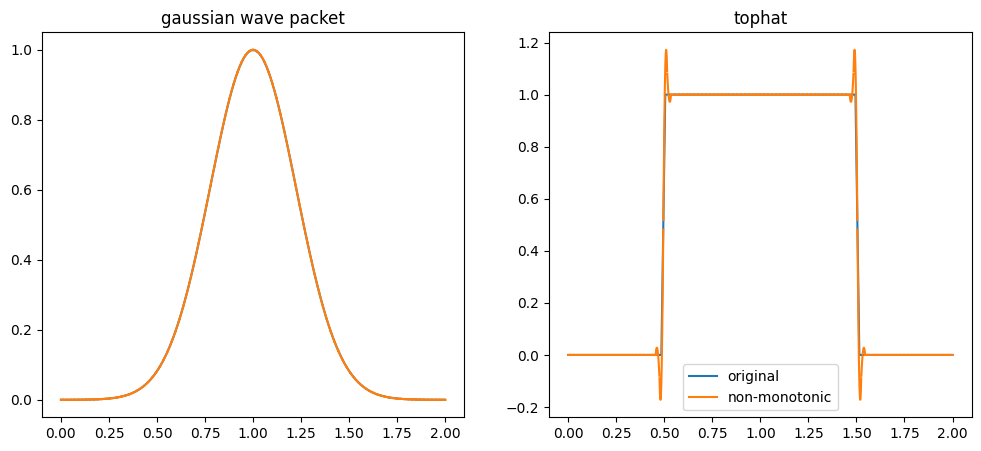

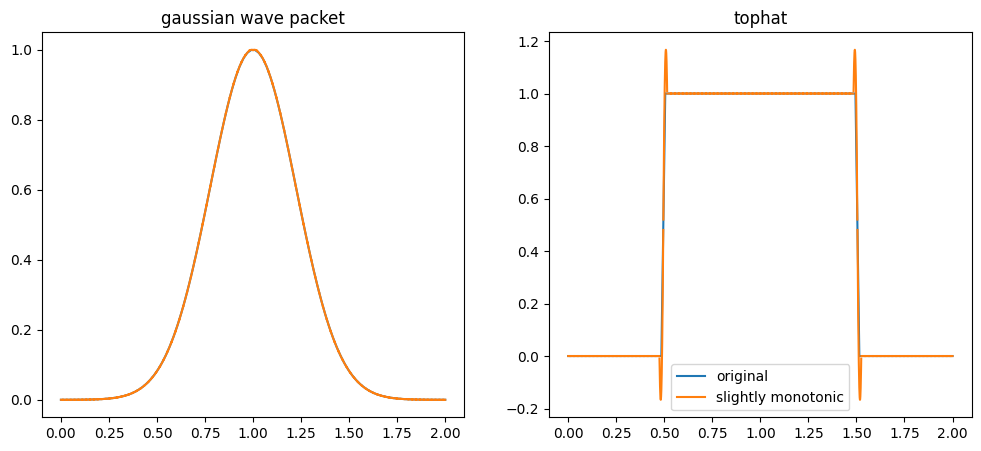

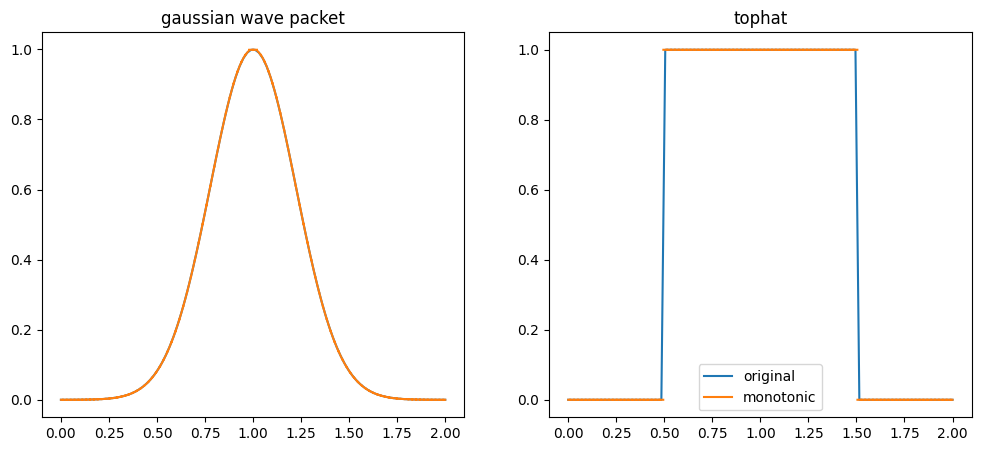

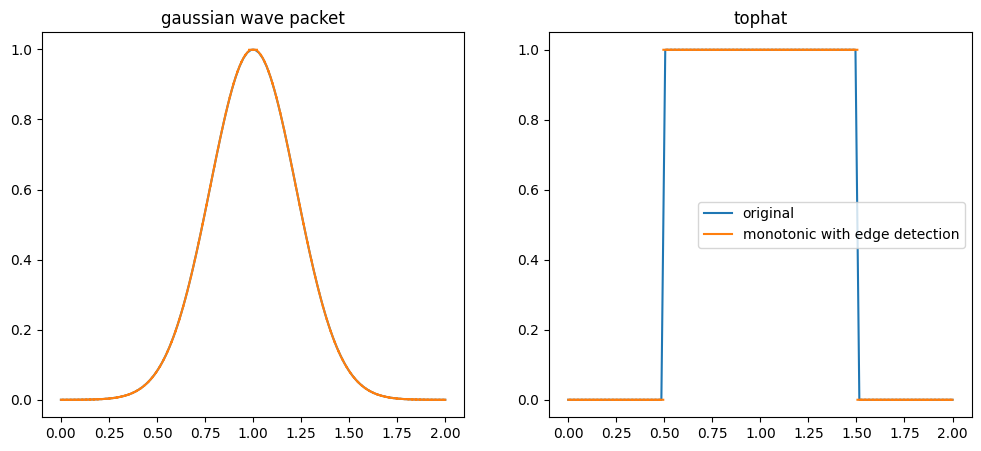

In [50]:
for label in ["non-monotonic", "slightly monotonic", "monotonic", "monotonic with edge detection"]:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    for i, (key, profile) in enumerate(interpolated_profiles.items()):
        axs[i].set_title(key)
        axs[i].plot(profile["original"]["xx"], profile["original"]["yy"], label="original") 
        axs[i].plot(profile[label]["xx"], profile[label]["yy"], label=label) 
    plt.legend()
    plt.show()

## Check derivatives of parabola

In [65]:
def dxgaussian1D(xx, dx, t=0, x0 = 1, v = 1, alpha = 1/10):
    psi = -2 * (xx-x0-t*v) / alpha * np.exp(-(xx-x0-t*v)**2/alpha)
    return psi

dy1p = dxgaussian1D(xx_hr, dx)
dy1m = dxgaussian1D(xx_hr, dx)
dy2p = np.zeros(xx_hr.shape)
dy2m = np.zeros(xx_hr.shape)


dyyp = [dy1p, dy2p]
dyym = [dy1m, dy2m]

In [66]:
def interpolate_da(xi, dxi, xx, a_L, a_R, d_a, a_6):
    #Interate over all interpolation intervals
    for i, xi_0 in enumerate(xx):
        # Check if xi lies in correct interval
        if (xi_0 - dxi/2 <= xi) and (xi < xi_0+ dxi/2):
            x = (xi - (xi_0 - dxi/2))/dxi
            return 1/dxi * (d_a[i] + a_6[i] * ( 1 - 2 * x))

interpolated_dprofiles = {}

for i, test_case in enumerate(interpolation_results):
    interpolated_dprofiles[labels[i]] = {}

    interpolated_dprofiles[labels[i]]["original"] = {"xx": xx_hr, "yy": dyyp[i]}
    for key in test_case.keys(): 
        yy_hr = np.zeros(xx_hr.shape) 
        for j, xi in enumerate(xx_hr): 
            yy_hr[j] = interpolate_da(xi, dx, xx, *test_case[key])
        interpolated_dprofiles[labels[i]][key] = {"xx": xx_hr, "yy": yy_hr}

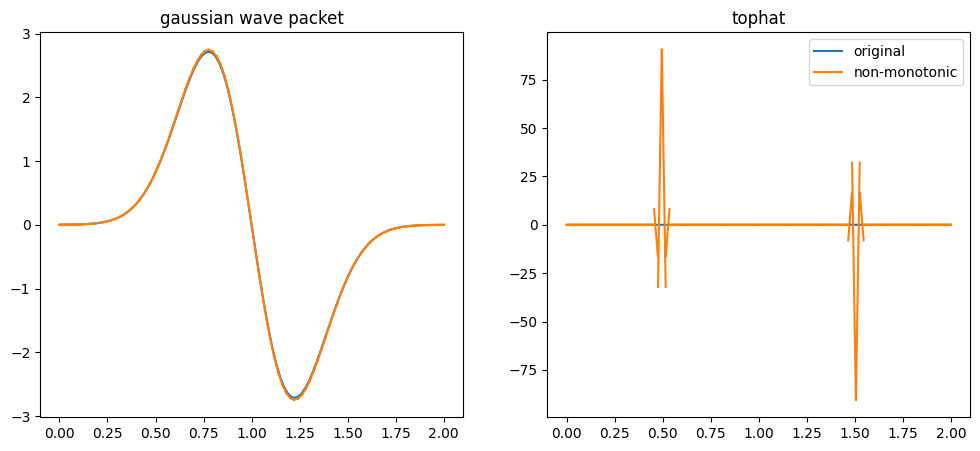

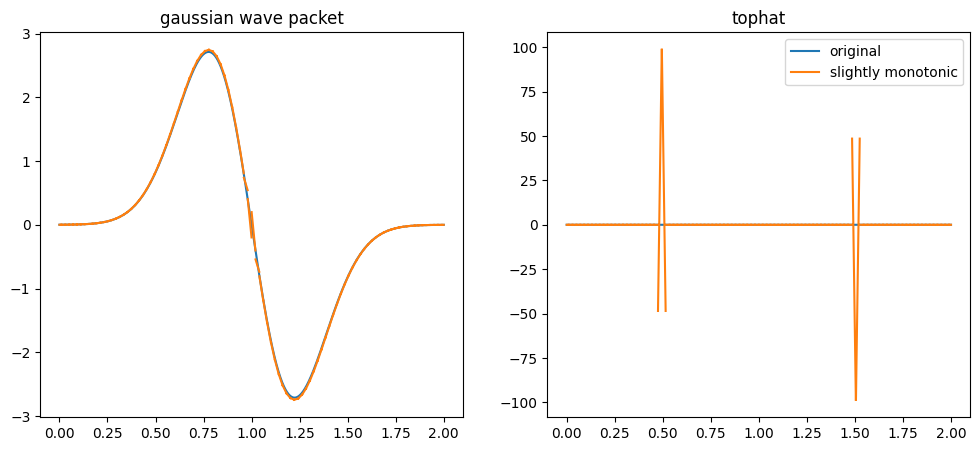

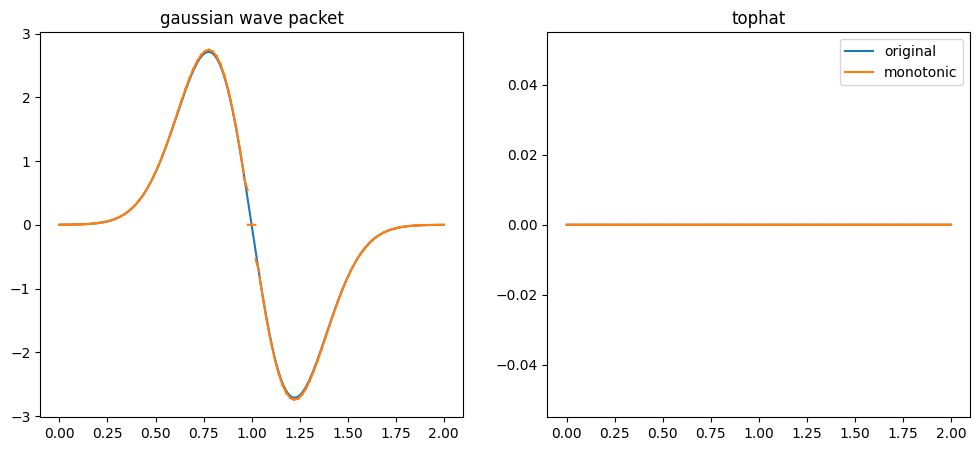

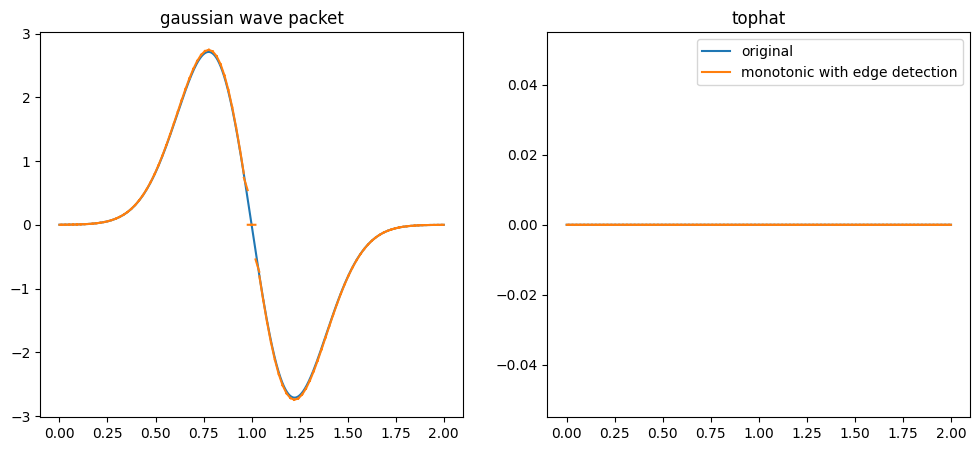

In [67]:
for label in ["non-monotonic", "slightly monotonic", "monotonic", "monotonic with edge detection"]:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    for i, (key, profile) in enumerate(interpolated_dprofiles.items()):
        axs[i].set_title(key)
        axs[i].plot(profile["original"]["xx"], profile["original"]["yy"], label="original") 
        axs[i].plot(profile[label]["xx"], profile[label]["yy"], label=label) 
    plt.legend()
    plt.show()